tgb - 4/26/2019  
The goal is to build the PDF of precipitation for the +0K and +4K based on different neural networks.
  
We use the standard feed-forward configuration of the neural network:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 

# 1) Load modules and create training/validation data generators

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


tgb - 4/18/2019 - Used preprocessed data calculated in notebook 009 @ https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/009_Generalization_Climate_Change_8col.ipynb

In [3]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('./nn_config/scale_dicts/009_Wm2_dP.pkl')

# train_gen = DataGenerator(
#     data_fn = TRAINDIR+PREFIX+'train_shuffle.nc',
#     input_vars = in_vars,
#     output_vars = out_vars,
#     norm_fn = TRAINDIR+PREFIX+'norm.nc',
#     input_transform = ('mean', 'maxrs'),
#     output_transform = scale_dict,
#     batch_size=1024,
#     shuffle=True
# )
# valid_gen = DataGenerator(
#     data_fn = TRAINDIR+PREFIX+'valid.nc',
#     input_vars = in_vars,
#     output_vars = out_vars,
#     norm_fn = TRAINDIR+PREFIX+'norm.nc',
#     input_transform = ('mean', 'maxrs'),
#     output_transform = scale_dict,
#     batch_size=1024,
#     shuffle=False
# )

## 2) Develop precipitation PDF module of the Model Diagnostics object

## 2.1) Load architecture-constrained network

In [2]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

NN = {}
%cd $TRAINDIR/HDF5_DATA
path = TRAINDIR+'HDF5_DATA/NNL0.01.h5'
NN = load_model(path,custom_objects=dict_lay)
md3 = ModelDiagnostics(NN,config_fn,data_fn)

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


## 2.2 Build PDF of precip  
tgb - 4/26/2019 - Skeleton code of precip PDF  
1) Predict total dimensional precipitation on batch  
2) Accumulate in linearly spaced precipitation bins that go up to 350mm/d (based on Figure 2a of PNAS)  
3) Repeat for each batch to accumulate full PDF

In [3]:
# Nbin = 100
# Pmax = 350
# Pmin = 0
# PHIST = np.zeros(Nbin)

# P_CONV = 1e3*24*3600 # Conversion from m/s to mm/day

# for itime in range(25):
#     print(itime)
#     # 1) Predict total precipitation on batch (liquid equivalent in mm/day)
#     X, truth = md.valid_gen[itime]
#     pred = md.model.predict_on_batch(X)
#     PRECIP = (np.sum(pred[:,-4:],axis=1))*P_CONV/(L_V*RHO_L)

#     # 2) Calculate histogram
#     PRECIP_HIST,bin_edge = np.histogram(PRECIP,range=(Pmin,Pmax),bins=Nbin)

#     # 3) Accumulate histogram
#     PHIST += PRECIP_HIST


#md3.compute_precipPDF(niter=25)

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
Loading model  JNNL
Loading statistics from  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10
/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10


Loading statistics from  /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc
Loading model  JNNC
Loading statistics from  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc
Loading statistics from  /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc
Loading model  JNNL0.01


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10
/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10


Loading statistics from  /local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc
Loading statistics from  /local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10
/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10


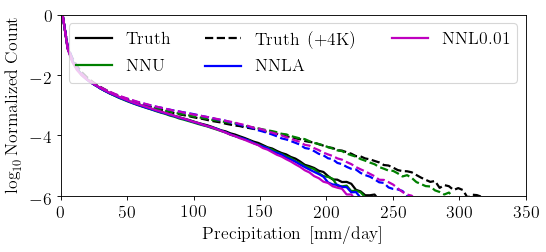

In [7]:
%cd $TRAINDIR/HDF5_DATA
TRUE = {}; PRED0 = {}; PRED4 = {};

option = 1; # 0 is lin scale and 1 is log scale, 2 is comparison from truth 
XLIM = (0,350); YLIM = (-6,0); # Option 
#XLIM = (0,50); YLIM = (-3,0)

config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_array = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
           '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc']
dataref = ['','4K']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
fz = 16
lw = 3
#NNarray = ['NNL0','NNL0.01','NNA','MLRL0','NNA0.01']
NNarray = ['JNNL','JNNC','JNNL0.01']
siz = 50

COL = ['g','b','m','r','y']
XLAB = [r'$\log_{10}\mathrm{Precipitation\ \left[mm/day\right]}$',
        r'$\mathrm{Precipitation\ \left[mm/day\right]}$']
YLAB = [r'$\mathrm{Normalized\ Count}$',r'$\log_{10}\mathrm{Normalized\ Count}$']
LABTRUE = [r'$\mathrm{Truth}$',r'$\mathrm{Truth\ \left(+4K\right)}$']
# LABPRED = [r'$\mathrm{NNU}$',r'$\mathrm{NNL0.01}$',
#             r'$\mathrm{NNA}$',r'$\mathrm{MLR}$',
#            r'$\mathrm{NNA0.01}$'          
#           ]
LABPRED = [r'$\mathrm{NNU}$',r'$\mathrm{NNLA}$',
            r'$\mathrm{NNL0.01}$'          
          ]
LABPRED4 = ['','','','','']
LIN = ['-','--']
MAR = ['o','P']
lw = 2

from matplotlib import pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)

plt.figure(num=None, figsize=(7.5,3), dpi=80, facecolor='w', edgecolor='k')

for i,NNs in enumerate(NNarray):
    NN = {}
    print('Loading model ',NNs)
    NN = load_model(TRAINDIR+'HDF5_DATA/'+NNs+
                    '.h5',custom_objects=dict_lay)
    for j,data_fn in enumerate(data_fn_array):
        md = {};
        md = ModelDiagnostics(NN,config_fn,data_fn)
        print('Loading statistics from ',data_fn) # 2) Define model diagnostics object
        md.precip = pickle.load(
            open(TRAINDIR+'HDF5_DATA/'+
                 NNs+'mdprecip'+
                 dataref[j]+'.pkl','rb'))

        dens = md.precip['predcount']/np.sum(md.precip['predcount'])
        if i==0:
            Tdens = md.precip['truecount']/np.sum(md.precip['truecount'])
            if option==0: Y = Tdens; X = np.log10(md.precip['bins'])
            elif option==1: Y = np.log10(Tdens); X = md.precip['bins']
            elif option==2: Y = np.nan*X
            TRUE[j] = plt.plot(X,Y,color='k',linewidth=lw,linestyle=LIN[j],label=LABTRUE[j])
                               #,marker=MAR[j],s=siz)
        if option==0: Y = dens
        elif option==1: Y = np.log10(dens)
        elif option==2: Y = np.log10(np.abs(dens-Tdens))
        if j==0: PRED0[i] = plt.plot(X,Y,color=COL[i],linewidth=lw,linestyle=LIN[j],label=LABPRED[i])
                                     #marker=MAR[j],s=siz)
        elif j==1: PRED4[i] = plt.plot(X,Y,color=COL[i],linewidth=lw,linestyle=LIN[j],label=LABPRED4[i])
                                       #marker=MAR[j],s=siz)
        
plt.xlabel(XLAB[option]); plt.xlim(XLIM) 
plt.ylabel(YLAB[option]); plt.ylim(YLIM)
plt.legend(ncol=3)
# plt.legend((TRUE[0],PRED0[0],PRED0[1],PRED0[2],PRED0[3],TRUE[1]),\
#            (r'$\mathrm{Truth}$',r'$\mathrm{NNU}$',r'$\mathrm{NNL0.01}$',
#             r'$\mathrm{NNA}$',r'$\mathrm{MLR}$',r'$\mathrm{Truth\ \left(+4K\right)}$'))

In [10]:
NN = load_model('Jordan02.h5',custom_objects=dict_lay)

ValueError: No model found in config file.

In [4]:
# NNarray = ['NNL0','NNL0.01','NNA','MLRL0']

# for i in range(len(NNarray)):
#     print(i)
#     # Load statistics
#     md = {}; NN = {};
#     print('Loading model') # 1) Load model
#     NN = load_model(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'.h5',custom_objects=dict_lay)
#     print('Loading statistics') # 2) Define model diagnostics object
#     md = ModelDiagnostics(NN,config_fn,data_fn)
#     # 3) Calculate statistics and save in pickle file
#     md.compute_precipPDF(niter=2)
#     pickle.dump(md.precip,open(TRAINDIR+'HDF5_DATA/'+NNarray[i]+'mdprecip.pkl','wb'))

In [10]:
md.precip

{'predcount': array([1.3350113e+07, 3.6461200e+06, 1.5117360e+06, 8.2978600e+05,
        5.3280100e+05, 3.7605800e+05, 2.8122100e+05, 2.1547800e+05,
        1.6875300e+05, 1.3338300e+05, 1.0735500e+05, 8.7087000e+04,
        7.1564000e+04, 5.8792000e+04, 4.9093000e+04, 4.1697000e+04,
        3.5792000e+04, 3.1439000e+04, 2.7315000e+04, 2.4146000e+04,
        2.1945000e+04, 1.9961000e+04, 1.8098000e+04, 1.6782000e+04,
        1.5586000e+04, 1.4651000e+04, 1.3687000e+04, 1.3221000e+04,
        1.2441000e+04, 1.1685000e+04, 1.1237000e+04, 1.0794000e+04,
        1.0248000e+04, 9.8710000e+03, 9.2520000e+03, 8.9390000e+03,
        8.6740000e+03, 8.1920000e+03, 7.9100000e+03, 7.6140000e+03,
        7.2370000e+03, 6.9820000e+03, 6.6780000e+03, 6.6150000e+03,
        6.2860000e+03, 6.0320000e+03, 5.7620000e+03, 5.5560000e+03,
        5.5150000e+03, 5.2260000e+03, 4.9980000e+03, 4.8060000e+03,
        4.6480000e+03, 4.4070000e+03, 4.2240000e+03, 3.9770000e+03,
        3.8880000e+03, 3.7460000e+0